In [18]:
import numpy as np
import sympy as sp
import pandas as pd
import matplotlib.pyplot as plt

In [19]:
#function to find covariance matrix
def covariance_matrix(data):
    mean_vector = np.mean(data, axis=0)
    z_matrix = data - mean_vector
    cov_matrix = np.dot(z_matrix.T, z_matrix) / (data.shape[0] - 1)
    return cov_matrix

### Load Dataset

In [20]:
data = pd.read_csv('face feature vectors.csv').drop('Unnamed: 0', axis=1)
data.rename(columns={'Unnamed: 1':'Gender'}, inplace=True)
data

,Gender,0,1,2,3,4,5,6,7,8,...,118,119,120,121,122,123,124,125,126,127
0,male,-0.066420,0.151611,0.027740,0.052771,-0.066105,-0.041232,-0.002637,-0.158467,0.130467,...,0.025989,-0.001087,0.027260,-0.046754,-0.118619,-0.163774,-0.000590,-0.076400,0.107497,0.001567
1,male,-0.030614,0.049667,0.008084,-0.050324,0.007649,-0.063818,-0.019530,-0.119905,0.186553,...,0.044229,-0.023900,-0.028108,0.040618,-0.146579,-0.141244,0.016162,0.017638,0.080610,-0.015930
2,male,-0.096178,0.061127,0.035326,-0.035388,-0.090728,-0.018634,-0.024315,-0.139786,0.052211,...,0.111141,0.059436,-0.029222,0.042115,-0.222173,-0.116908,0.093428,0.017391,0.057652,0.086116
3,male,-0.103057,0.085044,0.078333,-0.035873,-0.028163,0.004924,0.007829,-0.017016,0.114907,...,0.100793,-0.002644,-0.023388,0.029497,-0.139830,-0.119243,0.005306,-0.015100,0.161575,0.062462
4,male,-0.125815,0.120046,0.023131,-0.042901,0.038215,-0.049677,-0.054258,-0.130758,0.173457,...,0.090197,0.067527,0.039926,0.047469,-0.056852,-0.076700,0.004966,0.028171,0.026041,0.084135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,female,-0.164731,0.064301,0.058630,-0.017420,-0.157600,-0.022536,0.002864,-0.072739,0.030554,...,0.095115,0.007198,-0.004655,0.023957,-0.170753,-0.136630,0.041614,0.031600,0.019064,0.004384
796,female,-0.095308,0.051095,0.092913,-0.101745,-0.083153,-0.028159,0.009090,-0.114513,0.157421,...,0.056078,0.119846,0.087470,0.017481,-0.096594,-0.084553,0.037709,0.030732,-0.083713,0.064970
797,female,-0.202852,0.037039,0.079731,-0.047156,-0.140062,-0.080246,0.057668,-0.122083,0.165443,...,0.066954,0.035684,-0.023112,-0.030452,-0.154243,-0.188270,0.071086,0.037384,-0.006257,0.039977
798,female,-0.088300,0.063530,0.049627,-0.026011,-0.172773,0.086218,0.042710,-0.161852,0.185083,...,0.039460,0.067547,0.040426,0.028007,-0.154515,-0.127736,0.046967,0.009701,-0.016942,0.048071


### Train Test Split

In [21]:
def train_test_split(data, class_column, test_size = 40):
    classes = data[class_column].unique()
    test, train = pd.DataFrame(), pd.DataFrame()
    for c in classes:
        currentClass = data[data[class_column] == c]
        test = pd.concat([test, currentClass.iloc[:test_size, :]], ignore_index=True)
        train = pd.concat([train, currentClass.iloc[test_size:, :]], ignore_index=True)
    train_X, train_y = train.iloc[:, 1:], train.iloc[:, 0]
    test_X, test_y = test.iloc[:, 1:], test.iloc[:, 0]
    return train_X, train_y, test_X, test_y

In [22]:
train_X, train_y, test_X, test_y = train_test_split(data, 'Gender', 5)

### Bayes Classifier

In [23]:
def fit_bayes_classifier(train_X, train_y):
    classes = train_y.unique()
    cov_mats, cov_dets = {}, {}
    inv_cov_mats = {}
    for c in classes:
        cov_mats[c] = covariance_matrix(np.array(train_X[train_y == c]))
        cov_dets[c] = sp.Matrix(cov_mats[c]).det()
        inv_cov_mats[c] = np.linalg.inv(cov_mats[c])
    return cov_dets, inv_cov_mats

def bayes_classifier(train_X, train_y, test_X, cov_dets, inv_cov_mats):
    classes = train_y.unique()
    dimensions = train_X.shape[1]
    class_probabilities = {}

    for c in classes:
        apriori = len(train_y[train_y == c]) / len(train_y)
        mean_vector = np.array(train_X[train_y == c].mean())
        req_matrix = test_X - mean_vector
        numerator = np.exp(-0.5 * np.dot(np.dot(req_matrix.T, inv_cov_mats[c]), req_matrix))
        denominator = np.power(2 * np.pi, dimensions / 2) * np.power(cov_dets[c], 0.5)
        class_probabilities[c] = apriori * (numerator / denominator)

    return max(zip(class_probabilities.values(), class_probabilities.keys()))[1]

In [24]:
pred_y = []
cov_dets, inv_cov_mats = fit_bayes_classifier(train_X, train_y)
for i in range(len(test_X)):
    pred_y.append(bayes_classifier(train_X, train_y, test_X.iloc[i, :], cov_dets, inv_cov_mats))
comparison = pd.DataFrame({'Actual': test_y, 'Predicted': pred_y})
comparison

,Actual,Predicted
0,male,male
1,male,male
2,male,male
3,male,male
4,male,male
5,female,male
6,female,female
7,female,female
8,female,female
9,female,female


In [25]:
accuracies = {}
print("Class Accuracies:")
for c in test_y.unique():
    accuracies[c] = len(comparison[(comparison['Actual'] == c) & (comparison['Predicted'] == c)]) / len(comparison[comparison['Actual'] == c])
    print(c, ":", accuracies[c])
accuracies['Overall'] = len(comparison[comparison['Actual'] == comparison['Predicted']]) / len(comparison)
print("\nOverall Accuracy:", accuracies['Overall'])

Class Accuracies:
male : 1.0
female : 0.8

Overall Accuracy: 0.9


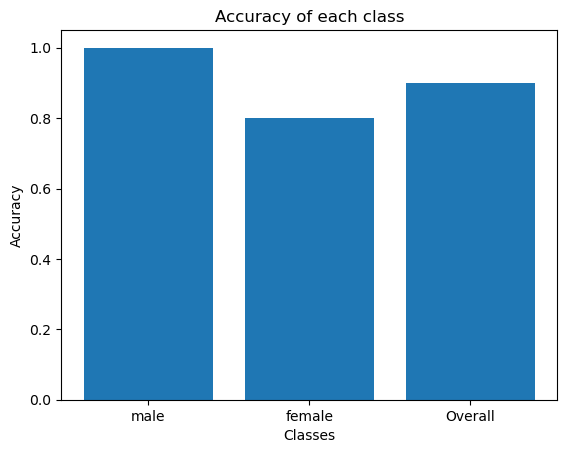

In [26]:
plt.bar(accuracies.keys(), accuracies.values())
plt.xlabel('Classes')
plt.ylabel('Accuracy')
plt.title('Accuracy of each class')
plt.show()